In [1]:
from common_preamble import *

searching for scad in: /Users/caseyschneider-mizell/anaconda3/envs/jupyter_space/bin:/Users/caseyschneider-mizell/.gem/ruby/2.7.0/bin:/usr/local/opt/ruby/bin:/Users/drpoo/anaconda3/bin:/anaconda3/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Applications/VMware Fusion.app/Contents/Public:/Library/TeX/texbin:/opt/X11/bin:/Applications/OpenSCAD.app/Contents/MacOS


Loading data from /Users/caseyschneider-mizell/Work/allen_work/data_analysis/ais_analysis_pipeline/data/in/data_v185_ais_bounds_v3_is_chandelier_v5.h5


Minimum AIS length: 37187.05055806807
	Computing aggregate AIS information


In [2]:
from ais_synapse_utils import aggregate_ais_dataframes

ais_synapse_filter = ais_synapse_data['d_top_skel'] < min_ais_len
ais_synapse_data_f = ais_synapse_data[ais_synapse_filter]

aggregated_ais_syn_df = aggregate_ais_dataframes(complete_ais_ids, ais_synapse_data_f)
aggregated_ais_syn_df = aggregated_ais_syn_df[aggregated_ais_syn_df['ais_len'] >= min_ais_len].reset_index()

	Computing aggregate AIS information


---

1) For each AIS and each ChC, get actual and potential connectivity table.

2) For each ChC, get its actual AISes.

3) For each ChC->AIS edge, get the other AISes and list the potential ChCs that also target the same original one.

In [3]:
mm = trimesh_io.MeshMeta(disk_cache_path=mesh_dir,
                         cache_size=0, cv_path=mesh_cv_path, voxel_scaling=voxel_scaling)

ais_meshes = {}
for oid in complete_ais_ids:
    ais_mesh_fname = f'{mesh_dir}/ais_meshes/{oid}_ais.h5'
    ais_mesh = mm.mesh(filename=ais_mesh_fname)
    ais_meshes[oid] = ais_mesh
    
ais_sks = []
for oid, ais_mesh in zip(complete_ais_ids, ais_meshes):
    ais_sk_filename = f'{skel_dir}/sk_ais_{oid}.h5'
    sk = skeleton_io.read_skeleton_h5(ais_sk_filename)
    sk.voxel_scaling = voxel_scaling
    ais_sks.append(sk)

soma_df = dl.query_cell_ids(soma_table)
chc_soma_ids = soma_df['pt_root_id'][np.isin(soma_df['pt_root_id'], chc_ids)].values
    
chc_meshes = {}
for oid in chc_ids:
    if oid not in chc_soma_ids:
        chc_mesh = mm.mesh(seg_id=oid)
    else:
        chc_mesh = mm.mesh(filename=mesh_dir + '/{}_axon.h5'.format(oid))
    chc_meshes[oid] = chc_mesh

In [10]:
np.isin(ais_sk.mesh_to_skel_map, np.flatnonzero(ais_sk.distance_to_root<min_ais_len)).

(1872137,)

In [4]:
ais_meshes_trunc = {}
for ii, oid in enumerate(complete_ais_ids):
    ais_sk = ais_sks[ii]
    trunc_mesh = ais_meshes[oid].apply_mask(np.isin(ais_sk.mesh_to_skel_map, np.flatnonzero(ais_sk.distance_to_root<min_ais_len)))
    ais_meshes_trunc[oid] = trunc_mesh

ValueError: Incompatible shape. Must be either original length or current length of vertices.

In [ ]:
from numbers import Number

def potential_connection(objectA, objectB, max_distance, return_indices=False, use_pykdtree=True):
    if isinstance(max_distance, Number):
        if use_pykdtree is True:
            kdtree_A = objectA.pykdtree
            if return_indices:
                kdtree_B = objectB.pykdtree
        else:
            kdtree_A = objectA.kdtree
            if return_indices:
                kdtree_B = objectB.kdtree
                
        ds, _ = kdtree_A.query(objectB.vertices, distance_upper_bound=max_distance)
        object_b_index_mask = ds<=max_distance
        is_close = np.any(object_b_index_mask)
        if return_indices is False:
            return is_close
        else:
            ds_BtoA, _ = kdtree_B.query(objectA.vertices, distance_upper_bound=max_distance)
            object_a_index_mask = ds_BtoA <= max_distance
            return is_close, object_a_index_mask, object_b_index_mask
    else:
        qrys = [potential_connection(objectA, objectB, max_distance=d, return_indices=return_indices, use_pykdtree=use_pykdtree) for d in max_distance]
        if return_indices:
            is_close_vec = np.array([q[0] for q in qrys])
            object_a_vec = [q[1] for q in qrys]
            object_b_vec = [q[2] for q in qrys]
            return is_close_vec, object_a_vec, object_b_vec
        else:
            return np.array(qrys)


In [ ]:
import tqdm

In [ ]:
fraction_cutoff = 0.1
mask_frac_df = pd.read_hdf(base_dir + '/data/mask_fraction_data_v{}.hdf'.format(data_version))
ais_oid_within_limits = mask_frac_df[mask_frac_df['d_{}'.format(10000)] < fraction_cutoff]['root_id']

In [ ]:
import copy
complete_ais_ids_orig = copy.copy(complete_ais_ids)
complete_ais_ids=np.intersect1d(complete_ais_ids, ais_oid_within_limits)

In [ ]:
ds = [5000, 7500, 10000, 15000]

chc_id_long = []
ais_id_long = []
is_close_long = []
pbar = tqdm.tqdm(total=len(chc_ids)*len(complete_ais_ids))
for chc_id in chc_ids:
    for ais_id in complete_ais_ids:
        pbar.update(1)
        is_close = potential_connection(chc_meshes[chc_id], ais_meshes_trunc[ais_id], max_distance=ds)
        chc_id_long.append(chc_id)
        ais_id_long.append(ais_id)
        is_close_long.append(is_close)
pbar.close()

In [50]:
close_ind = 1
potential_df = pd.DataFrame(data={'chc_id':chc_id_long,
                                   'ais_id':ais_id_long,
                                   f'is_close_{ds[0]}':[x[0] for x in is_close_long],
                                   f'is_close_{ds[1]}':[x[1] for x in is_close_long],
                                   f'is_close_{ds[2]}':[x[2] for x in is_close_long],
                                   })

chc_to_ais_el = ais_synapse_data[['pre_pt_root_id', 'post_pt_root_id', 'is_chandelier']].query('is_chandelier==True').groupby(['pre_pt_root_id', 'post_pt_root_id']).count().reset_index()

potential_df = potential_df.merge(chc_to_ais_el, how='left', left_on=['chc_id', 'ais_id'], right_on=['pre_pt_root_id', 'post_pt_root_id']).drop(columns=['pre_pt_root_id', 'post_pt_root_id'])
potential_df = potential_df.fillna(0).rename(columns={'is_chandelier':'actual_syn'})

potential_df['is_actual'] = potential_df.eval('actual_syn>0')

For every pair of ChCs, look for co-targets.

Configuration model total counting

1) For every AIS, get its potential partners

2) For the real data, for all co-potentials, count the number of 0s, 1s, and 2s in ChC->AIS co-targeting.

3) Make shuffled networks from the configuration model where each AIS assigns the observed number of connections to potential partners.

In [11]:
from analysisdatalink import connectivity

In [13]:
rel_d = 7500

dmax = rel_d
el = connectivity.edgelist_from_synapse_df(ais_synapse_data_f.query(f'post_pt_root_id in {complete_ais_ids.tolist()}').query('is_chandelier==True'), weight_column='syn_per_edge')

bipartite_actual = el.pivot_table(index='pre_pt_root_id', columns='post_pt_root_id', values='weight', fill_value=0)
# Make sure to include cells with no ChCs
col_ids_to_add = complete_ais_ids[~np.isin(complete_ais_ids, bipartite_actual.columns)]
for oid in col_ids_to_add:
    bipartite_actual[oid] = 0

bipartite_potential = potential_df.pivot_table(index='chc_id', columns='ais_id', values=f'is_close_{dmax}')
bipartite_potential_reduced = bipartite_potential.loc[bipartite_actual.index][bipartite_actual.columns]

ba = bipartite_actual.values>0
bp = bipartite_potential_reduced.values.astype(int)

---
Power analysis. Take the potential graph and with some probability perturb it in favor of co-contact.

In [14]:
import copy 

def shuffle_contact_network(ba, bp, alpha, w_cocontact, n_times=1, seed=None):
    '''
    Shuffle each edge with probability alpha.
    Weight edges with previous co-contacts with weight w_cocontact (vs weight 1 for non-cocontact)
    '''
    if seed is not None:
        np.random.seed(seed)
        
    ba = copy.copy(ba)
    
    n = 0
    while n < n_times:
        ais_order = np.random.permutation(np.arange(ba.shape[1]))
        for ais_ind in ais_order:
            chc_ind_order = np.random.permutation(np.flatnonzero(ba[:,ais_ind]))
            for chc_ind in chc_ind_order:
                # Do shuffle
                if np.random.rand() < alpha:
                    # Remove edge
                    ba[chc_ind, ais_ind] = False

                    # Get potential ChCs
                    actual_chc_inds = np.flatnonzero(ba[:,ais_ind])
                    potential_chc_inds = np.setdiff1d(np.flatnonzero(bp[:, ais_ind]), actual_chc_inds)

                    # Which chcs are co-contacts?
                    cocontact_ais_inds = np.setdiff1d(np.flatnonzero(np.sum(ba[actual_chc_inds,:], axis=0)>0), [ais_ind])
                    cocontact_options = np.flatnonzero(ba[potential_chc_inds][:, cocontact_ais_inds].sum(axis=1)>0)

                    choice_weights = np.ones(len(potential_chc_inds))
                    choice_weights[cocontact_options] = w_cocontact

                    new_chc_ind = np.random.choice(potential_chc_inds, p=choice_weights/np.sum(choice_weights))
                    ba[new_chc_ind, ais_ind] = True
        n = n+1
    return ba


In [15]:
def cotarget_motif_type2(ba, bp):
    is_cotarget_motif = []
    is_cotarget_motif_actual = []
    for ais_ind in range(ba.shape[1]):
        is_cotarget_motif.append(0)
        is_cotarget_motif_actual.append(0)
        actual_chc_inds = np.flatnonzero(ba[:, ais_ind])
        potential_chc_inds = np.flatnonzero(bp[:, ais_ind])
        for chc_ind in potential_chc_inds:
            my_other_ais_inds = np.setdiff1d(np.flatnonzero(ba[chc_ind, :]), [ais_ind])
            other_chc_inds = np.setdiff1d(actual_chc_inds, [chc_ind])
            for other_chc_ind in other_chc_inds:
                their_other_ais_inds = np.setdiff1d(np.flatnonzero(ba[other_chc_ind, :]), [ais_ind])
                if np.any(np.isin(my_other_ais_inds, their_other_ais_inds)):
                    is_cotarget_motif[-1] += 1
                    if chc_ind in actual_chc_inds:
                        is_cotarget_motif_actual[-1] += 1
    return is_cotarget_motif, is_cotarget_motif_actual, sum(is_cotarget_motif_actual)/sum(is_cotarget_motif)

In [30]:
is_cotarget_motif, is_cotarget_motif_actual, cotarget_fraction_observed = cotarget_motif_type2(ba, bp)
p_doublet_observed = cotarget_fraction
print(p_doublet_observed)

0.3891891891891892


In [23]:
import multiwrapper.multiprocessing_utils as mu

def _multi_shuffle(data):
    ba, bp, alpha, n_times, seed = data
    new_ba = shuffle_contact_network(ba, bp, 1, alpha, n_times, seed=None)
    _, _, cotarget_fraction = cotarget_motif_type2(new_ba, bp)
    return cotarget_fraction

In [36]:
N = 1000
alphas = np.arange(0.1, 2.51, 0.1)
n_times = 5

cotarget_fraction_moved = []
for alpha in tqdm.tqdm(alphas):
    seeds = np.random.randint(0, 10000000, size=N)
    data = []
    for ii in range(N):
        data.append((ba, bp, alpha, n_times, seeds[ii]))
    shuffled_fractions = mu.multiprocess_func(_multi_shuffle, data)
    cotarget_fraction_moved.append(shuffled_fractions)

data_df = pd.DataFrame(data={alphas[ii]:cts for ii, cts in enumerate(cotarget_fraction_moved)})
comp_df = data_df.unstack().reset_index().rename(columns={'level_0':'alpha', 0:'MotifConnectionProb'}).drop(columns=['level_1'])



  0%|          | 0/3 [00:02<?, ?it/s]Process ForkPoolWorker-82:
Process ForkPoolWorker-83:
Process ForkPoolWorker-81:
Process ForkPoolWorker-80:
Traceback (most recent call last):
  File "/Users/caseyschneider-mizell/anaconda3/envs/data_analysis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):



KeyboardInterrupt: 

  File "/Users/caseyschneider-mizell/anaconda3/envs/data_analysis/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/caseyschneider-mizell/anaconda3/envs/data_analysis/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/caseyschneider-mizell/anaconda3/envs/data_analysis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/caseyschneider-mizell/anaconda3/envs/data_analysis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/caseyschneider-mizell/anaconda3/envs/data_analysis/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/caseyschneider-mizell/anaconda3/envs/data_analysis/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(

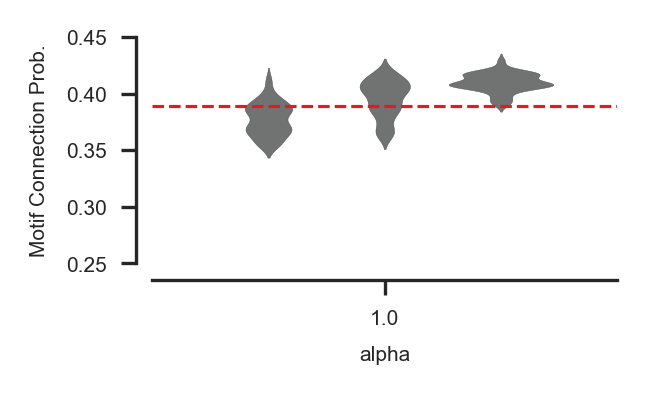

In [40]:
fig, ax = plt.subplots(figsize=(2,1), dpi=300)
sns.violinplot(ax=ax, x='alpha', y='MotifConnectionProb',
               inner=None, linewidth=0.1, width=0.9, color=non_color,
               data=comp_df)
ax.hlines(xmin=-1, xmax=len(alphas), y=cotarget_fraction_observed, color=chc_color, linestyle='--', linewidth=0.75)
ax.set_xlabel('alpha')
ax.set_xticks(np.arange(1,len(alphas),2))
ax.set_yticks(np.arange(0.25, 0.5, 0.05))
ax.set_ylabel('Motif Connection Prob.')
ax.set_xlim(-1, len(alphas))
sns.despine(ax=ax, offset=4)
set_axis_fonts(ax, tick_font={'size':5}, label_font={'size':5}, yprecision=2)
# _=ax.set_xticklabels([f'{al:.1f}' if np.mod(ii,2)==1 else '' for ii, al in enumerate(alphas)])
_=ax.set_xticklabels([f'{al:.1f}' for ii, al in enumerate(alphas[1::2])])

ps = []
pso = []
for cf in cotarget_fraction_moved:
    ps.append(np.sum(np.array(cf)<cotarget_fraction_observed) / len(cf))
    pso.append(np.sum(np.array(cf)>cotarget_fraction_observed) / len(cf))

n_stars = np.full(len(alphas), 0)
n_stars[np.logical_or( np.array(ps)<0.05, np.array(pso)<0.05)] = 1
star_ys=[np.percentile(cm, 95) for cm in cotarget_fraction_moved]
plot_stars(np.arange(0, len(alphas)), star_ys, n_stars, ax=ax, xytext=(0,8), fontsize=4, color=chc_color, horizontalalignment='center')

fig.savefig(f'{plot_dir}/power_analysis_panel.pdf', bbox_inches='tight')

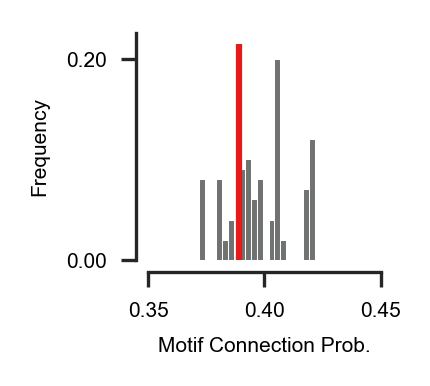

In [31]:
flat_rand_ind = np.flatnonzero(np.array(alphas)==1)[0]

figsize = (1,1)
dpi = 300
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
bary, barx = np.histogram(cotarget_fraction_moved[flat_rand_ind], bins=20)
ax.bar(barx[:-1], bary/np.sum(bary), color=non_color, width=np.mean(np.diff(barx)), linewidth=0.25, align='edge')
ax.vlines(x=cotarget_fraction_observed, ymin=0, ymax=max(bary/np.sum(bary)+0.015), color=chc_color, linewidth=1.5 )
ax.set_ylabel('Frequency')
ax.set_xlabel('Motif Connection Prob.')
ax.set_xticks(np.arange(0.35, 0.45, 0.05))
sns.despine(ax=ax, offset=3)
set_axis_fonts(ax, tick_font={'size':5, 'color':'k'}, xprecision=2, yprecision=2, label_font={'size':5, 'color':'k'})

# fig.savefig(f'{plot_dir}/motif_analysis_randomized.pdf', bbox_inches='tight')

## d = 5000

In [58]:
rel_d = 5000
N = 1000

dmax = rel_d
el = connectivity.edgelist_from_synapse_df(ais_synapse_data_f.query(f'post_pt_root_id in {complete_ais_ids.tolist()}').query('is_chandelier==True'), weight_column='syn_per_edge')

bipartite_actual = el.pivot_table(index='pre_pt_root_id', columns='post_pt_root_id', values='weight', fill_value=0)
# Make sure to include cells with no ChCs
col_ids_to_add = complete_ais_ids[~np.isin(complete_ais_ids, bipartite_actual.columns)]
for oid in col_ids_to_add:
    bipartite_actual[oid] = 0

bipartite_potential = potential_df.pivot_table(index='chc_id', columns='ais_id', values=f'is_close_{dmax}')
bipartite_potential_reduced = bipartite_potential.loc[bipartite_actual.index][bipartite_actual.columns]

ba = bipartite_actual.values>0
bp = bipartite_potential_reduced.values.astype(int)

is_cotarget_motif, is_cotarget_motif_actual, cotarget_fraction_observed = cotarget_motif_type2(ba, bp)

##########

alphas = np.arange(0.1, 2.51, 0.1)
n_times = 5

cotarget_fraction_moved = []
for alpha in tqdm.tqdm(alphas):
    seeds = np.random.randint(0, 10000000, size=N)
    data = []
    for ii in range(N):
        data.append((ba, bp, alpha, n_times, seeds[ii]))
    shuffled_fractions = mu.multiprocess_func(_multi_shuffle, data)
    cotarget_fraction_moved.append(shuffled_fractions)

data_df = pd.DataFrame(data={alphas[ii]:cts for ii, cts in enumerate(cotarget_fraction_moved)})
comp_df = data_df.unstack().reset_index().rename(columns={'level_0':'alpha', 0:'MotifConnectionProb'}).drop(columns=['level_1'])

####



  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [06:33<2:37:15, 393.13s/it]

  8%|▊         | 2/25 [12:50<2:28:50, 388.29s/it]

 12%|█▏        | 3/25 [19:10<2:21:28, 385.82s/it]

 16%|█▌        | 4/25 [25:44<2:15:56, 388.38s/it]

 20%|██        | 5/25 [32:07<2:08:56, 386.80s/it]

 24%|██▍       | 6/25 [39:50<2:09:40, 409.49s/it]

 28%|██▊       | 7/25 [46:28<2:01:51, 406.17s/it]

 32%|███▏      | 8/25 [52:42<1:52:23, 396.65s/it]

 36%|███▌      | 9/25 [58:56<1:43:55, 389.72s/it]

 40%|████      | 10/25 [1:05:13<1:36:29, 385.97s/it]

 44%|████▍     | 11/25 [1:11:44<1:30:21, 387.28s/it]

 48%|████▊     | 12/25 [1:18:07<1:23:38, 386.03s/it]

 52%|█████▏    | 13/25 [1:24:34<1:17:17, 386.43s/it]

 56%|█████▌    | 14/25 [1:30:48<1:10:10, 382.76s/it]

 60%|██████    | 15/25 [1:37:31<1:04:46, 388.68s/it]

 64%|██████▍   | 16/25 [1:44:06<58:36, 390.67s/it]  

 68%|██████▊   | 17/25 [1:49:41<49:51, 374.00s/it]

 72%|███████▏  | 18/25 [1:55:18<42:19, 362.79s/it]

 76%|███████▌  | 

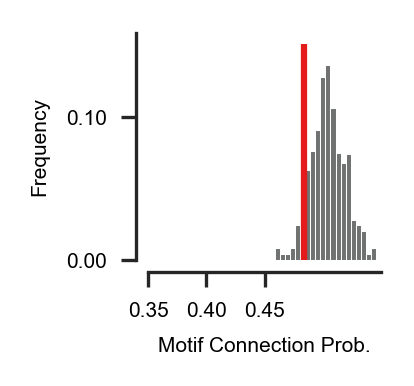

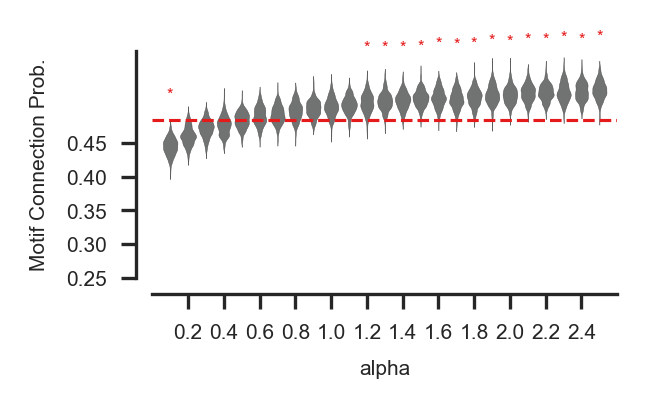

In [58]:
flat_rand_ind = np.flatnonzero(np.array(alphas)==1)[0]

figsize = (1,1)
dpi = 300
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
bary, barx = np.histogram(cotarget_fraction_moved[flat_rand_ind], bins=20)
ax.bar(barx[:-1], bary/np.sum(bary), color=non_color, width=np.mean(np.diff(barx)), linewidth=0.25, align='edge')
ax.vlines(x=cotarget_fraction_observed, ymin=0, ymax=max(bary/np.sum(bary)+0.015), color=chc_color, linewidth=1.5 )
ax.set_ylabel('Frequency')
ax.set_xlabel('Motif Connection Prob.')
ax.set_xticks(np.arange(0.35, 0.45, 0.05))
sns.despine(ax=ax, offset=3)
set_axis_fonts(ax, tick_font={'size':5, 'color':'k'}, xprecision=2, yprecision=2, label_font={'size':5, 'color':'k'})

# fig.savefig(f'{plot_dir}/motif_analysis_randomized_{rel_d}.pdf', bbox_inches='tight')

####

fig, ax = plt.subplots(figsize=(2,1), dpi=300)
sns.violinplot(ax=ax, x='alpha', y='MotifConnectionProb',
               inner=None, linewidth=0.1, width=0.9, color=non_color,
               data=comp_df)
ax.hlines(xmin=-1, xmax=len(alphas), y=cotarget_fraction_observed, color=chc_color, linestyle='--', linewidth=0.75)
ax.set_xlabel('alpha')
ax.set_xticks(np.arange(1,len(alphas),2))
ax.set_yticks(np.arange(0.25, 0.5, 0.05))
ax.set_ylabel('Motif Connection Prob.')
ax.set_xlim(-1, len(alphas))
sns.despine(ax=ax, offset=4)
set_axis_fonts(ax, tick_font={'size':5}, label_font={'size':5}, yprecision=2)
# _=ax.set_xticklabels([f'{al:.1f}' if np.mod(ii,2)==1 else '' for ii, al in enumerate(alphas)])
_=ax.set_xticklabels([f'{al:.1f}' for ii, al in enumerate(alphas[1::2])])

ps = []
pso = []
for cf in cotarget_fraction_moved:
    ps.append(np.sum(np.array(cf)<cotarget_fraction_observed) / len(cf))
    pso.append(np.sum(np.array(cf)>cotarget_fraction_observed) / len(cf))

n_stars = np.full(len(alphas), 0)
n_stars[np.logical_or( np.array(ps)<0.05, np.array(pso)<0.05)] = 1
star_ys=[np.percentile(cm, 95) for cm in cotarget_fraction_moved]
plot_stars(np.arange(0, len(alphas)), star_ys, n_stars, ax=ax, xytext=(0,8), fontsize=4, color=chc_color, horizontalalignment='center')

# fig.savefig(f'{plot_dir}/power_analysis_panel_{rel_d}.pdf', bbox_inches='tight')



  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [07:00<2:48:04, 420.17s/it]

  8%|▊         | 2/25 [13:41<2:38:52, 414.45s/it]

 12%|█▏        | 3/25 [20:20<2:30:20, 410.03s/it]

 16%|█▌        | 4/25 [26:55<2:21:52, 405.37s/it]

 20%|██        | 5/25 [33:33<2:14:23, 403.19s/it]

 24%|██▍       | 6/25 [40:19<2:07:55, 403.98s/it]

 28%|██▊       | 7/25 [47:03<2:01:13, 404.10s/it]

 32%|███▏      | 8/25 [53:40<1:53:54, 402.01s/it]

 36%|███▌      | 9/25 [1:00:25<1:47:23, 402.71s/it]

 40%|████      | 10/25 [1:07:35<1:42:43, 410.90s/it]

 44%|████▍     | 11/25 [1:14:19<1:35:23, 408.82s/it]

 48%|████▊     | 12/25 [1:21:08<1:28:35, 408.86s/it]

 52%|█████▏    | 13/25 [1:27:58<1:21:50, 409.24s/it]

 56%|█████▌    | 14/25 [1:34:44<1:14:52, 408.43s/it]

 60%|██████    | 15/25 [1:41:32<1:08:00, 408.07s/it]

 64%|██████▍   | 16/25 [1:48:22<1:01:19, 408.83s/it]

 68%|██████▊   | 17/25 [1:55:18<54:47, 410.90s/it]  

 72%|███████▏  | 18/25 [2:02:39<48:59, 419.89s/it]

 76%|███████▌

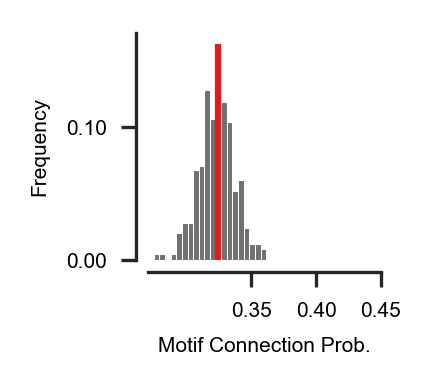

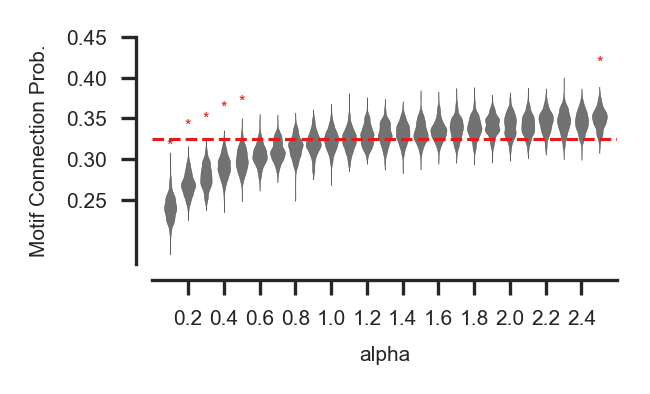

In [59]:
rel_d = 10000
N = 1000

dmax = rel_d
el = connectivity.edgelist_from_synapse_df(ais_synapse_data_f.query(f'post_pt_root_id in {complete_ais_ids.tolist()}').query('is_chandelier==True'), weight_column='syn_per_edge')

bipartite_actual = el.pivot_table(index='pre_pt_root_id', columns='post_pt_root_id', values='weight', fill_value=0)
# Make sure to include cells with no ChCs
col_ids_to_add = complete_ais_ids[~np.isin(complete_ais_ids, bipartite_actual.columns)]
for oid in col_ids_to_add:
    bipartite_actual[oid] = 0

bipartite_potential = potential_df.pivot_table(index='chc_id', columns='ais_id', values=f'is_close_{dmax}')
bipartite_potential_reduced = bipartite_potential.loc[bipartite_actual.index][bipartite_actual.columns]

ba = bipartite_actual.values>0
bp = bipartite_potential_reduced.values.astype(int)

is_cotarget_motif, is_cotarget_motif_actual, cotarget_fraction_observed = cotarget_motif_type2(ba, bp)

##########

alphas = np.arange(0.1, 2.51, 0.1)
n_times = 5

cotarget_fraction_moved = []
for alpha in tqdm.tqdm(alphas):
    seeds = np.random.randint(0, 10000000, size=N)
    data = []
    for ii in range(N):
        data.append((ba, bp, alpha, n_times, seeds[ii]))
    shuffled_fractions = mu.multiprocess_func(_multi_shuffle, data)
    cotarget_fraction_moved.append(shuffled_fractions)

data_df = pd.DataFrame(data={alphas[ii]:cts for ii, cts in enumerate(cotarget_fraction_moved)})
comp_df = data_df.unstack().reset_index().rename(columns={'level_0':'alpha', 0:'MotifConnectionProb'}).drop(columns=['level_1'])

####

flat_rand_ind = np.flatnonzero(np.array(alphas)==1)[0]

figsize = (1,1)
dpi = 300
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
bary, barx = np.histogram(cotarget_fraction_moved[flat_rand_ind], bins=20)
ax.bar(barx[:-1], bary/np.sum(bary), color=non_color, width=np.mean(np.diff(barx)), linewidth=0.25, align='edge')
ax.vlines(x=cotarget_fraction_observed, ymin=0, ymax=max(bary/np.sum(bary)+0.015), color=chc_color, linewidth=1.5 )
ax.set_ylabel('Frequency')
ax.set_xlabel('Motif Connection Prob.')
ax.set_xticks(np.arange(0.35, 0.45, 0.05))
sns.despine(ax=ax, offset=3)
set_axis_fonts(ax, tick_font={'size':5, 'color':'k'}, xprecision=2, yprecision=2, label_font={'size':5, 'color':'k'})

fig.savefig(f'{plot_dir}/motif_analysis_randomized_{rel_d}.pdf', bbox_inches='tight')

####

fig, ax = plt.subplots(figsize=(2,1), dpi=300)
sns.violinplot(ax=ax, x='alpha', y='MotifConnectionProb',
               inner=None, linewidth=0.1, width=0.9, color=non_color,
               data=comp_df)
ax.hlines(xmin=-1, xmax=len(alphas), y=cotarget_fraction_observed, color=chc_color, linestyle='--', linewidth=0.75)
ax.set_xlabel('alpha')
ax.set_xticks(np.arange(1,len(alphas),2))
ax.set_yticks(np.arange(0.25, 0.5, 0.05))
ax.set_ylabel('Motif Connection Prob.')
ax.set_xlim(-1, len(alphas))
sns.despine(ax=ax, offset=4)
set_axis_fonts(ax, tick_font={'size':5}, label_font={'size':5}, yprecision=2)
# _=ax.set_xticklabels([f'{al:.1f}' if np.mod(ii,2)==1 else '' for ii, al in enumerate(alphas)])
_=ax.set_xticklabels([f'{al:.1f}' for ii, al in enumerate(alphas[1::2])])

ps = []
pso = []
for cf in cotarget_fraction_moved:
    ps.append(np.sum(np.array(cf)<cotarget_fraction_observed) / len(cf))
    pso.append(np.sum(np.array(cf)>cotarget_fraction_observed) / len(cf))

n_stars = np.full(len(alphas), 0)
n_stars[np.logical_or( np.array(ps)<0.05, np.array(pso)<0.05)] = 1
star_ys=[np.percentile(cm, 95) for cm in cotarget_fraction_moved]
plot_stars(np.arange(0, len(alphas)), star_ys, n_stars, ax=ax, xytext=(0,8), fontsize=4, color=chc_color, horizontalalignment='center')

fig.savefig(f'{plot_dir}/power_analysis_panel_{rel_d}.pdf', bbox_inches='tight')

---

In [55]:
cotarget_fraction_observed_5000

0.4838709677419355

In [64]:
from sklearn.cluster import bicluster

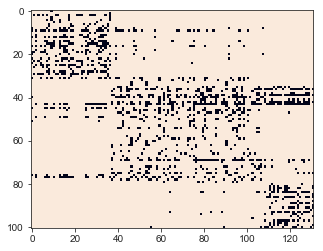

In [66]:
from sklearn.cluster import bicluster
sco = bicluster.SpectralCoclustering(n_clusters=3)

sco_res = sco.fit(bp)

newrow = np.argsort(sco_res.row_labels_)
newcol = np.argsort(sco_res.column_labels_)
plt.imshow(1-bp[:,newcol][newrow])

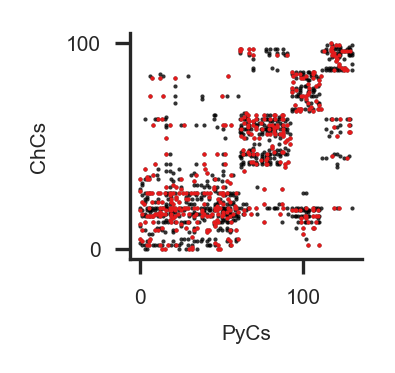

In [154]:
rel_d = 7500

dmax = rel_d
el = connectivity.edgelist_from_synapse_df(ais_synapse_data_f.query(f'post_pt_root_id in {complete_ais_ids.tolist()}').query('is_chandelier==True'), weight_column='syn_per_edge')

bipartite_actual = el.pivot_table(index='pre_pt_root_id', columns='post_pt_root_id', values='weight', fill_value=0)
# Make sure to include cells with no ChCs
col_ids_to_add = complete_ais_ids[~np.isin(complete_ais_ids, bipartite_actual.columns)]
for oid in col_ids_to_add:
    bipartite_actual[oid] = 0

bipartite_potential = potential_df.pivot_table(index='chc_id', columns='ais_id', values=f'is_close_{dmax}')
bipartite_potential_reduced = bipartite_potential.loc[bipartite_actual.index][bipartite_actual.columns]

ba = bipartite_actual.values>0
bp = bipartite_potential_reduced.values.astype(int)

###

from sklearn.cluster import bicluster
sco = bicluster.SpectralCoclustering(n_clusters=4)

sco_res = sco.fit(bp)

newrow = np.argsort(sco_res.row_labels_)
newcol = np.argsort(sco_res.column_labels_)

###

fig, ax = plt.subplots(figsize=(1,1), dpi=300)

yps, xps = np.where(bp[:,newcol][newrow])
ax.plot(xps, yps, 'k.', markersize=2, alpha=0.8, markeredgewidth=0)

yas, xas = np.where(ba[:,newcol][newrow])
ax.plot(xas, yas, '.', markersize=2, color=chc_color, alpha=1,
        markeredgewidth=0)

ax.set_xlabel('PyCs')
ax.set_ylabel('ChCs')
ax.set_xticks([0,100])
ax.set_yticks([0,100])
sns.despine(ax=ax)
set_axis_fonts(ax=ax, tick_font={'size':5}, xtick_int=True, ytick_int=True, label_font={'size':5})

fig.savefig(f'{plot_dir}/adjmat_chc_pyc_potential_7500.pdf', bbox_inches='tight')

130

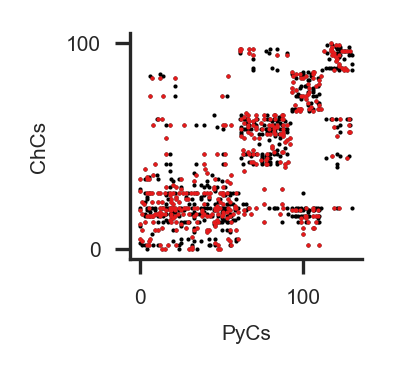

In [155]:
rel_d = 5000

dmax = rel_d

bipartite_potential = potential_df.pivot_table(index='chc_id', columns='ais_id', values=f'is_close_{dmax}')
bipartite_potential_reduced = bipartite_potential.loc[bipartite_actual.index][bipartite_actual.columns]
bp = bipartite_potential_reduced.values.astype(int)

###

fig, ax = plt.subplots(figsize=(1,1), dpi=300)

yps, xps = np.where(bp[:,newcol][newrow])
ax.plot(xps, yps, 'k.', markersize=2, markeredgewidth=0)

yas, xas = np.where(ba[:,newcol][newrow])
ax.plot(xas, yas, '.', markersize=2, color=chc_color, markeredgewidth=0)

ax.set_xlabel('PyCs')
ax.set_ylabel('ChCs')
ax.set_xticks([0,100])
ax.set_yticks([0,100])
sns.despine(ax=ax)
set_axis_fonts(ax=ax, tick_font={'size':5}, xtick_int=True, ytick_int=True, label_font={'size':5})

fig.savefig(f'{plot_dir}/adjmat_chc_pyc_potential_5000.pdf', bbox_inches='tight')

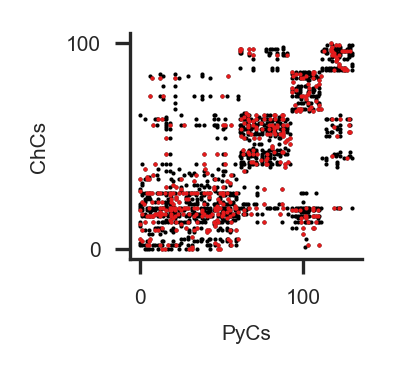

In [156]:
rel_d = 10000

dmax = rel_d
el = connectivity.edgelist_from_synapse_df(ais_synapse_data_f.query(f'post_pt_root_id in {complete_ais_ids.tolist()}').query('is_chandelier==True'), weight_column='syn_per_edge')

bipartite_actual = el.pivot_table(index='pre_pt_root_id', columns='post_pt_root_id', values='weight', fill_value=0)
# Make sure to include cells with no ChCs
col_ids_to_add = complete_ais_ids[~np.isin(complete_ais_ids, bipartite_actual.columns)]
for oid in col_ids_to_add:
    bipartite_actual[oid] = 0

bipartite_potential = potential_df.pivot_table(index='chc_id', columns='ais_id', values=f'is_close_{dmax}')
bipartite_potential_reduced = bipartite_potential.loc[bipartite_actual.index][bipartite_actual.columns]

ba = bipartite_actual.values>0
bp = bipartite_potential_reduced.values.astype(int)

###

fig, ax = plt.subplots(figsize=(1,1), dpi=300)

yps, xps = np.where(bp[:,newcol][newrow])
ax.plot(xps, yps, 'k.', markersize=2, markeredgewidth=0)

yas, xas = np.where(ba[:,newcol][newrow])
ax.plot(xas, yas, '.', markersize=2, color=chc_color, markeredgewidth=0)

ax.set_xlabel('PyCs')
ax.set_ylabel('ChCs')
ax.set_xticks([0,100])
ax.set_yticks([0,100])
sns.despine(ax=ax)
set_axis_fonts(ax=ax, tick_font={'size':5}, xtick_int=True, ytick_int=True, label_font={'size':5})

fig.savefig(f'{plot_dir}/adjmat_chc_pyc_potential_{rel_d}.pdf', bbox_inches='tight')

In [157]:
plt.imshow(1-ba[:,neword][newrow])

NameError: name 'neword' is not defined

In [ ]:
ba.sum() / bp.sum()

In [ ]:
chc_el = connectivity.edgelist_from_synapse_df(ais_synapse_data.query('is_chandelier==True'))

In [ ]:
num_chc_syn = aggregated_ais_syn_df['syn_net_chc'].values
num_cells = aggregated_ais_syn_df['num_cells_chc'].values
connection_weights = chc_el['weight'].values